In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

/srv/conda/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
from dask.distributed import Client, progress
# HPC
# client = Client(scheduler_file='/glade/scratch/jhamman/scheduler.json')
# client

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=10)
cluster

/srv/conda/lib/python3.6/site-packages/dask_kubernetes/config.py:13: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/srv/conda/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


In [3]:
client = Client(cluster)
client

Client Scheduler: tcp://10.32.2.65:45113 Dashboard: /user/0000-0002-5878-4501/proxy/45679/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='pangeo-181919', token='anon', access='read_only')

In [5]:
gcsmap = gcsfs.mapping.GCSMap('pangeo-data/llc4320_surface/Eta',gcs=fs,check=False,create=False)
ds = xr.open_zarr(gcsmap)

In [6]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables:
    Eta      (time, face, j, i) float32 dask.array<shape=(9030, 13, 4320, 4320), chunksize=(1, 1, 4320, 4320)>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [7]:
gcsmapgrid = gcsfs.mapping.GCSMap('pangeo-data/llc4320_surface/grid',gcs=fs,check=False,create=False)
dsgrid = xr.open_zarr(gcsmapgrid)

In [8]:
dsgrid

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k_p1: 2, time: 9030)
Coordinates:
    CS       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth    (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    PHrefC   float32 ...
    PHrefF   (k_p1) float32 dask.array<shape=(2,), chunksize=(2,)>
    SN       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XG       (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YG       (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Z        float32 ...
    Zl       float32 ...
    Zp1      (k_p1) float32 dask.array<shape=(2,), chunksize=(2

In [9]:
lat = dsgrid.YC
lon = dsgrid.XC

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

In [11]:
def plot_surf(sub,data,lon,lat,vmin,vmax,cmap,title,date):
    
    ax = plt.subplot(sub,projection=ccrs.PlateCarree(central_longitude=0))
    land = cfeature.GSHHSFeature(scale='intermediate',
                                 levels=[1],
                                 facecolor=cfeature.COLORS['land'])
    ax.add_feature(land)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)

    plt.pcolormesh(lon,lat,data,cmap=cmap,vmin=vmin,vmax=vmax )
    plt.colorbar(orientation='horizontal',pad=0.1, aspect=50)
    plt.title(title)
    ax.text(0.57, -0.08, date, transform=ax.transAxes)



In [12]:
data = ds.sel(time='2012-01-01T01:00:00',face=10)['Eta'] #.values
lonn = lon.sel(face=10) #.values
latt = lat.sel(face=10) #.values

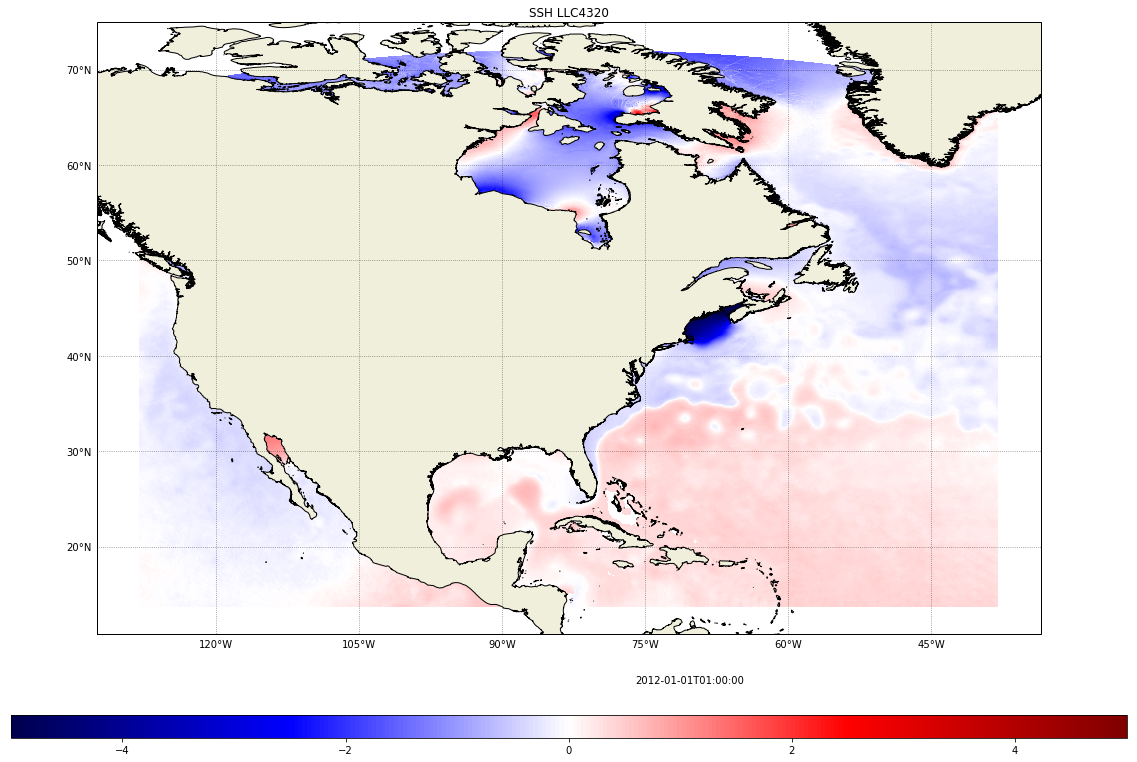

In [13]:
fig = plt.figure(figsize=(20,15))
plot_surf(111,data,lonn,latt,-5,5,div_cmap,'SSH LLC4320','2012-01-01T01:00:00')

In [14]:
lomin = -49.5
lomax = -47
lamin = 34
lamax = 36.5

In [15]:
lonEbox = lonn.where((lonn>lomin)&(lonn<lomax)&(latt>lamin)&(latt<lamax), drop=True)
latEbox = latt.where((lonn>lomin)&(lonn<lomax)&(latt>lamin)&(latt<lamax), drop=True)
adtEbox = data.where((lonn>lomin)&(lonn<lomax)&(latt>lamin)&(latt<lamax), drop=True)

In [16]:
lonEbox.shape

(120, 159)

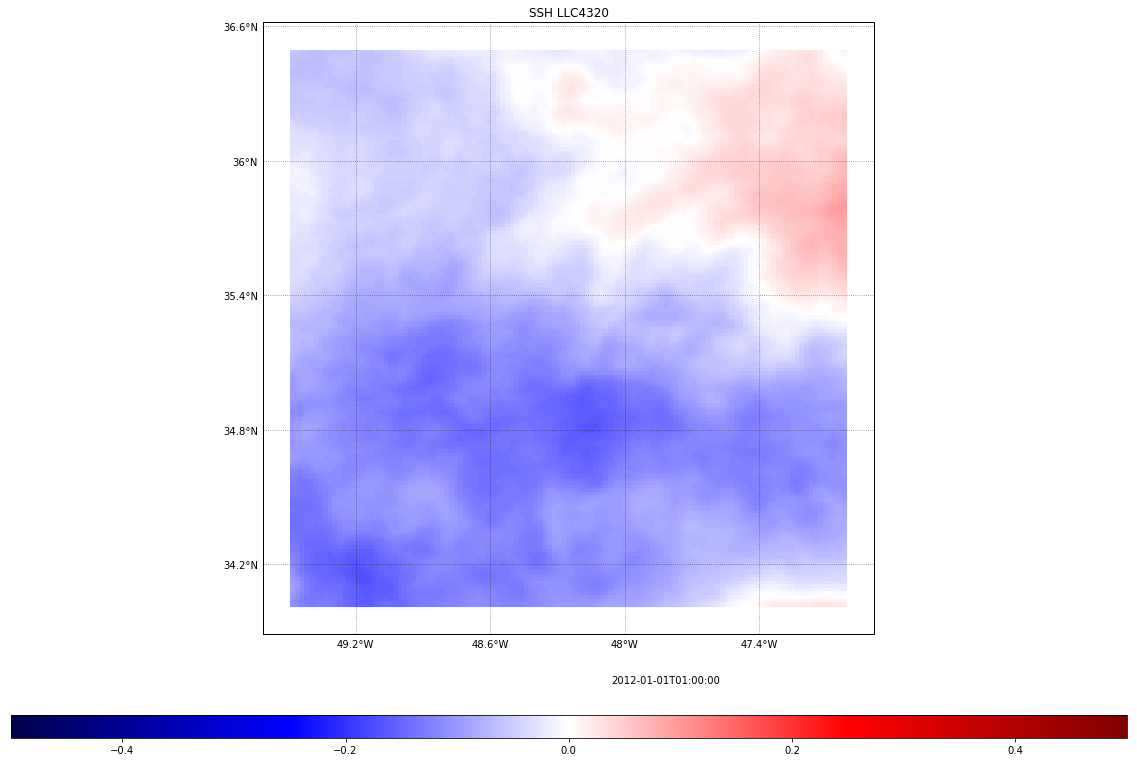

In [17]:
fig = plt.figure(figsize=(20,15))
plot_surf(111, adtEbox, lonEbox, latEbox, -.5, 0.5, div_cmap, 'SSH LLC4320', '2012-01-01T01:00:00')


# One file spectra:

In [18]:
lon_box = lonEbox.to_masked_array()
lat_box = latEbox.to_masked_array()
adt_box = adtEbox.to_masked_array()

In [19]:
import PowerSpec_old as ps

In [20]:
m2km = 1.E3

# All FMA:

In [21]:
data_box = ds.sel(face=10)['Eta']

In [22]:
data_box

<xarray.DataArray 'Eta' (time: 9030, j: 4320, i: 4320)>
dask.array<shape=(9030, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320)>
Coordinates:
    face     int64 10
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00

In [23]:
def is_amj(month):
    return (month >= 2) & (month <= 4)

seasonal_data = data_box.sel(time=is_amj(data_box['time.month']))

In [24]:
seasonal_data

<xarray.DataArray 'Eta' (time: 2160, j: 4320, i: 4320)>
dask.array<shape=(2160, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320)>
Coordinates:
    face     int64 10
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2012-02-01 ... 2012-04-30T23:00:00

# --> select in time and space --> cool!

In [25]:
seasonal_data.shape

(2160, 4320, 4320)

# Subselect in space the seasonal data:

In [26]:
seasonal_data_box = seasonal_data.where((lonn>lomin)&(lonn<lomax)&(latt>lamin)&(latt<lamax), drop=True)


In [27]:
seasonal_data_box

<xarray.DataArray 'Eta' (time: 2160, j: 120, i: 159)>
dask.array<shape=(2160, 120, 159), dtype=float32, chunksize=(1, 120, 159)>
Coordinates:
    face     int64 10
  * i        (i) int64 2996 2997 2998 2999 3000 ... 3150 3151 3152 3153 3154
  * j        (j) int64 3768 3769 3770 3771 3772 ... 3883 3884 3885 3886 3887
  * time     (time) datetime64[ns] 2012-02-01 ... 2012-04-30T23:00:00
    CS       (j, i) float32 dask.array<shape=(120, 159), chunksize=(120, 159)>
    Depth    (j, i) float32 dask.array<shape=(120, 159), chunksize=(120, 159)>
    PHrefC   float32 15.4017
    SN       (j, i) float32 dask.array<shape=(120, 159), chunksize=(120, 159)>
    XC       (j, i) float32 dask.array<shape=(120, 159), chunksize=(120, 159)>
    YC       (j, i) float32 dask.array<shape=(120, 159), chunksize=(120, 159)>
    Z        float32 -1.57
    Zl       float32 -1.0
    Zu       float32 -2.14
    drF      float32 1.14
    hFacC    (j, i) float32 dask.array<shape=(120, 159), chunksize=(120, 159)>
   

In [28]:
seasonal_data_box.shape

(2160, 120, 159)

In [29]:
adt_seasonal_box = seasonal_data_box.to_masked_array()

In [30]:
adt_seasonal_box.shape

(2160, 120, 159)

In [31]:
len(adt_seasonal_box)

2160

In [32]:
for ii in range(0, len(adt_seasonal_box)):

    x, y, data = ps.interpolate(adt_seasonal_box[ii,:,:], lon_box, lat_box, interp=None) #'basemap')
    # - check if data contains nan. If yes,replace with interpolated values.
    ##data = ps.isdata_contain_nan(data)
    # - compute sepctrum
    kstep_ssh_N, pspec_ssh_N = ps.get_spectrum(data, x, y, window='tukey', detrend='both')

    if ii==0:
        pspec_ssh_Nt = np.empty([len(pspec_ssh_N), len(adt_seasonal_box)])
    pspec_ssh_Nt[:, ii] = pspec_ssh_N


Text(0, 0.5, 'Spectral density [$m$$^2$ $/$ $cpkm$]')

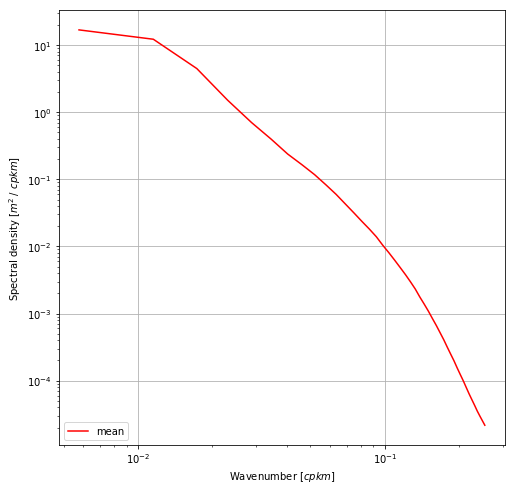

In [33]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
ax.loglog(kstep_ssh_N * m2km, pspec_ssh_Nt.mean(axis=1), 'r', label='mean')
ax.grid(True)
#ax.set_ylim([1e-5, 1e1])
#ax.set_xlim([5e-3, .2])
ax.legend(loc='lower left')
ax.set_xlabel('Wavenumber [$cpkm$]')
ax.set_ylabel('Spectral density [$m$$^2$ $/$ $cpkm$]')



In [34]:
def tick_function(X):
    W = 1 / (X) #(2 * np.pi)
    return ["%.3f" % z for z in W]

Text(0.5, 0, '$Wavenumber$ $[cy/km]$')

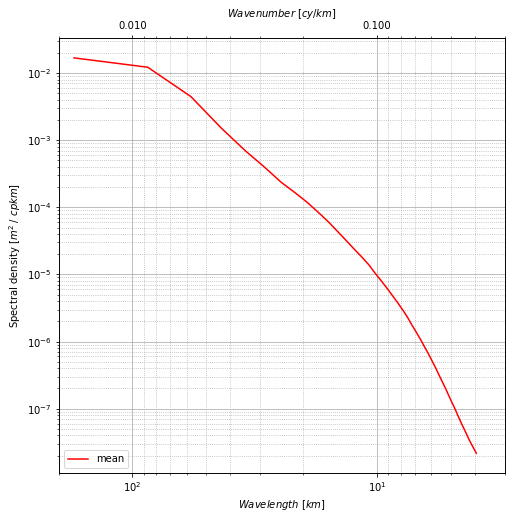

In [35]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
ax2 = ax.twiny()
ax.loglog((1./(kstep_ssh_N * m2km)), (pspec_ssh_Nt.mean(axis=1))/1000., 'r', label='mean')
ax.grid(b=True, which='major', linestyle='-') #, color='b'
ax.grid(b=True, which='minor', linestyle='dotted')
#ax.set_ylim([1e-5, 1e1])
ax.set_xlim([200., 3.])
ax.legend(loc='lower left')
#ax.set_xlabel('Wavenumber [$cpkm$]')
ax.set_xlabel('$Wavelength$ $[km]$')
ax.set_ylabel('Spectral density [$m$$^2$ $/$ $cpkm$]')
#ax1.axis([4e3, 1., 1e-10, 10.])
#ax1.set_title('Winter \n \n')
#ax1.text(0.95, 0.95, 'Winter', transform=ax1.transAxes, fontsize=14,
#        verticalalignment='top', horizontalalignment='right', bbox=props)
#ax1.legend(loc=0)
# add top x-axis
axTicks = ax.get_xticks()   
ax2Ticks = axTicks
ax2.set_xscale('log')
ax2.set_xticks(ax2Ticks)
ax2.set_xbound(ax.get_xbound())
ax2.set_xticklabels(tick_function(ax2Ticks))
ax2.invert_xaxis()
ax2.set_xlabel("$Wavenumber$ $[cy/km]$")


# --> y-axis, m2/ cpkm or km2/cpkm

Text(0, 0.5, 'Spectral density [$m$$^2$ $/$ $cpkm$]')

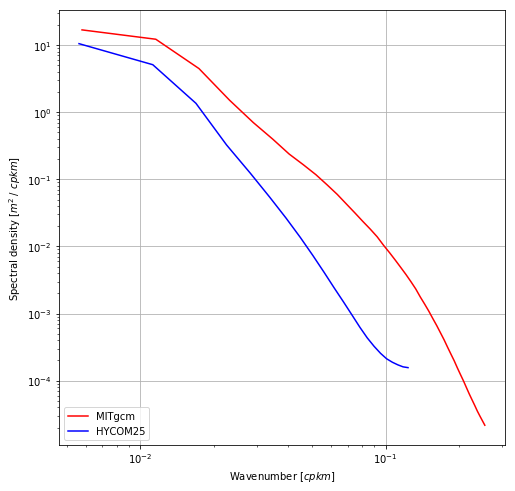

In [36]:
dHYCOM = np.load('/home/jovyan/git/jupyterlab_pangeo/kspectra_FMA_gst_HYCOM25.npz')

plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
ax.loglog(kstep_ssh_N * m2km, pspec_ssh_Nt.mean(axis=1), 'r', label='MITgcm')
ax.loglog(dHYCOM.f.kstep_ssh_H * m2km, dHYCOM.f.pspec_ssh_Ht.mean(axis=1), 'b', label='HYCOM25')
ax.grid(True)
#ax.set_ylim([1e-5, 1e1])
#ax.set_xlim([5e-3, .2])
ax.legend(loc='lower left')
ax.set_xlabel('Wavenumber [$cpkm$]')
ax.set_ylabel('Spectral density [$m$$^2$ $/$ $cpkm$]')



# Add NAtl60:

Text(0, 0.5, 'Spectral density [$m$$^2$ $/$ $cpkm$]')

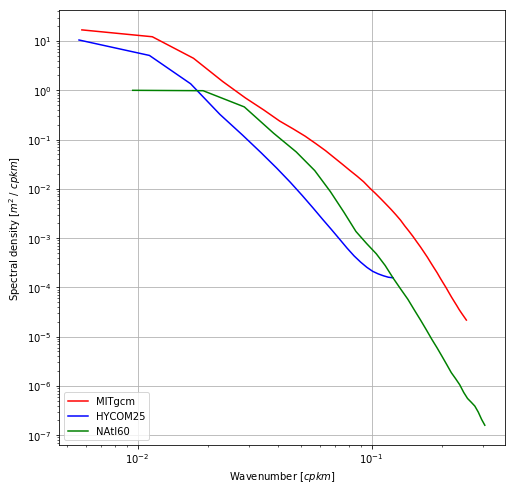

In [38]:
dNAtl60 = np.load('/home/jovyan/git/jupyterlab_pangeo/kspectra_FMA_gst_NAtl60.npz')

plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
ax.loglog(kstep_ssh_N * m2km, pspec_ssh_Nt.mean(axis=1), 'r', label='MITgcm')
ax.loglog(dHYCOM.f.kstep_ssh_H * m2km, dHYCOM.f.pspec_ssh_Ht.mean(axis=1), 'b', label='HYCOM25')
ax.loglog(dNAtl60.f.kstep_ssh_N * m2km, dNAtl60.f.pspec_ssh_Nt.mean(axis=1), 'g', label='NAtl60')
ax.grid(True)
#ax.set_ylim([1e-5, 1e1])
#ax.set_xlim([5e-3, .2])
ax.legend(loc='lower left')
ax.set_xlabel('Wavenumber [$cpkm$]')
ax.set_ylabel('Spectral density [$m$$^2$ $/$ $cpkm$]')



# --> NAtl60 smaller region (tech problems)